In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
    


In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


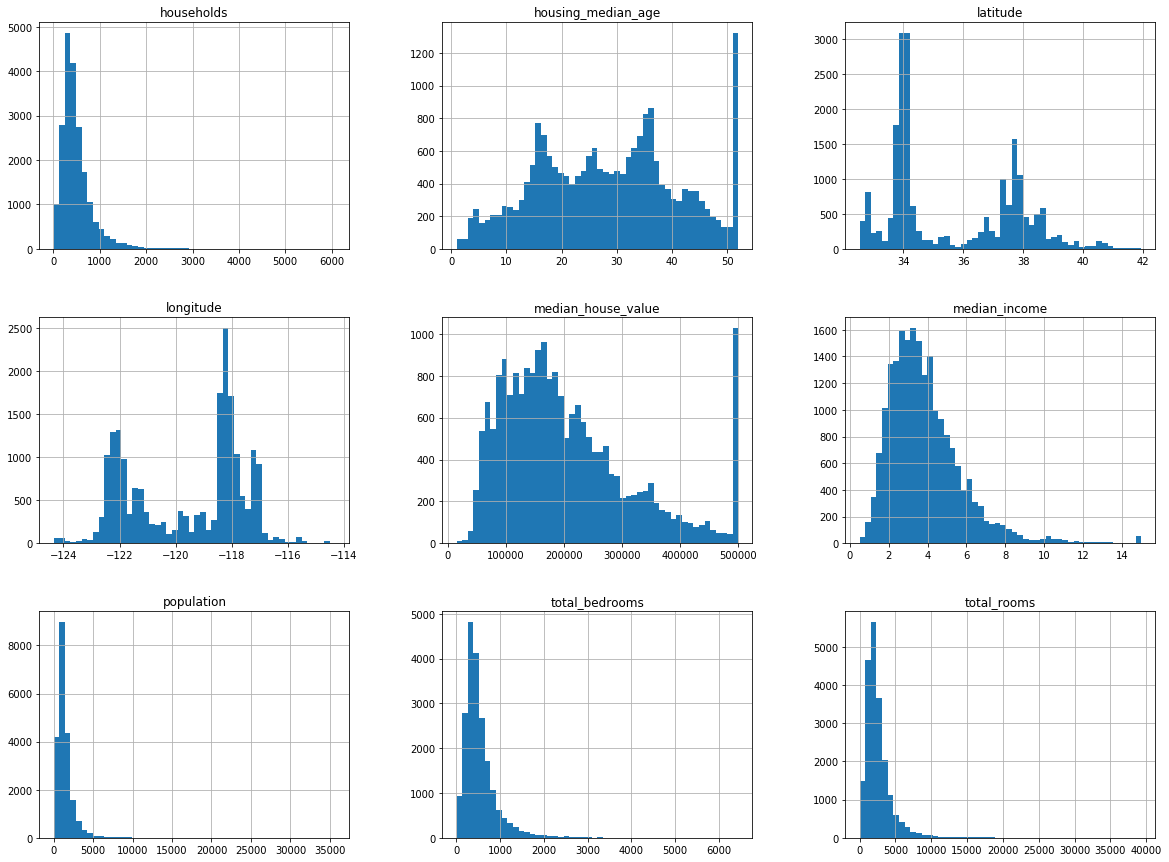

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins= 50, figsize=(20,15))
plt.show()

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [11]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] > 5, 5.0, inplace=True)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
 strat_train_set = housing.loc[train_index]
 strat_test_set = housing.loc[test_index]

In [17]:
housing["income_cat"].value_counts() / len(housing)

5.0     0.954506
6.0     0.025775
7.0     0.009157
8.0     0.005087
9.0     0.002422
11.0    0.002374
10.0    0.000678
Name: income_cat, dtype: float64

In [18]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis = 1, inplace = True)

In [19]:
housing = strat_train_set.copy()

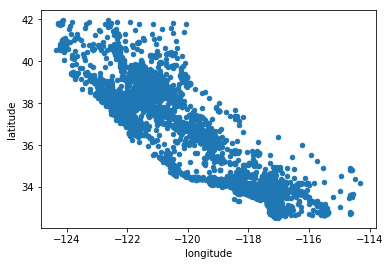

In [20]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

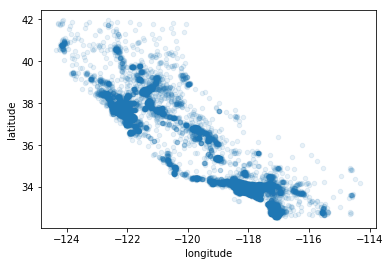

In [21]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

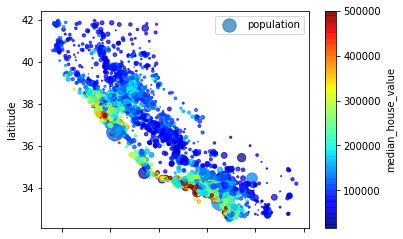

In [22]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.7, s = housing["population"]/100, label = "population", c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.686214
total_rooms           0.132777
housing_median_age    0.104035
households            0.065741
total_bedrooms        0.050092
population           -0.024797
longitude            -0.050312
latitude             -0.140169
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc37c1ba58>,
      dtype=object)

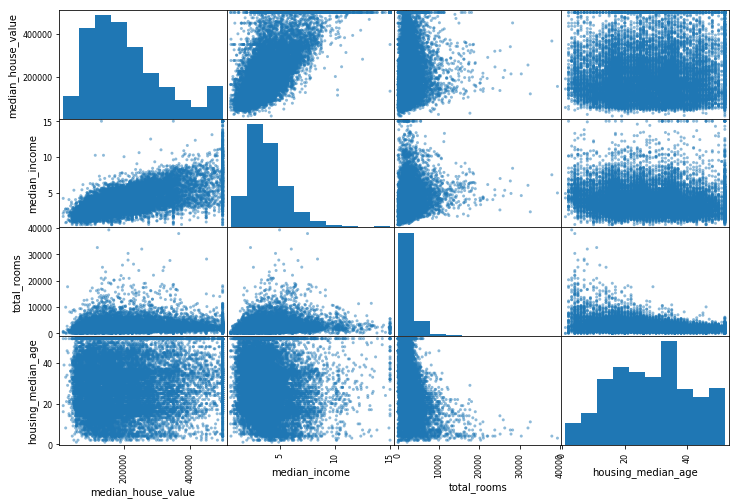

In [25]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

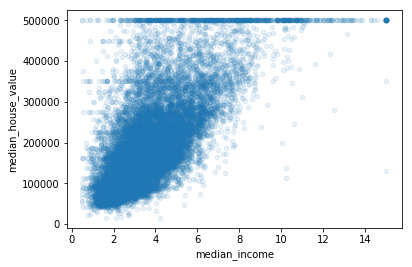

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [28]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.686214
rooms_per_household         0.158915
total_rooms                 0.132777
housing_median_age          0.104035
households                  0.065741
total_bedrooms              0.050092
population_per_household   -0.020748
population                 -0.024797
longitude                  -0.050312
latitude                   -0.140169
bedrooms_per_room          -0.253415
Name: median_house_value, dtype: float64

In [29]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
housing.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
16659,-120.67,35.30,32.0,4202.0,986.0,2309.0,956.0,2.2165,NEAR OCEAN
19735,-121.80,40.34,26.0,4815.0,910.0,1341.0,539.0,2.8810,INLAND
1566,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001,<1H OCEAN
16430,-121.35,38.09,32.0,1706.0,292.0,923.0,284.0,5.5057,INLAND
9111,-118.15,34.59,33.0,2111.0,429.0,1067.0,397.0,3.7344,INLAND
4803,-118.36,34.03,38.0,2365.0,638.0,2259.0,607.0,2.0879,<1H OCEAN
6711,-118.16,34.14,41.0,3039.0,482.0,973.0,446.0,7.4817,<1H OCEAN
10229,-117.93,33.86,36.0,931.0,279.0,778.0,303.0,2.6563,<1H OCEAN
19327,-122.91,38.49,37.0,2469.0,519.0,1137.0,474.0,3.6343,<1H OCEAN
10519,-117.68,33.57,2.0,10008.0,1453.0,3550.0,1139.0,10.1122,<1H OCEAN


In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

In [32]:
housing_num = housing.drop("ocean_proximity", axis = 1)

In [33]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [34]:
imputer.statistics_

array([-118.49  ,   34.255 ,   29.    , 2125.    ,  433.5   , 1165.    ,
        409.    ,    3.5296])

In [35]:
housing_num.median().values

array([-118.49  ,   34.255 ,   29.    , 2125.    ,  433.5   , 1165.    ,
        409.    ,    3.5296])

In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([4, 1, 0, ..., 0, 0, 1])

In [37]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories = "auto")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [39]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
 def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
     self.add_bedrooms_per_room = add_bedrooms_per_room
 def fit(self, X, y=None):
     return self # nothing else to do
 def transform(self, X, y=None):
     rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
     population_per_household = X[:, population_ix] / X[:, household_ix]
     if self.add_bedrooms_per_room:
         bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
    
         return np.c_[X, rooms_per_household, population_per_household,
                                 bedrooms_per_room]
     else:
         return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
         ('imputer', SimpleImputer(strategy="median")),
         ('attribs_adder', CombinedAttributesAdder()),
         ('std_scaler', StandardScaler()),
     ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [43]:
from sklearn.base import TransformerMixin
class MyLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelBinarizer()
    def fit(self, x, y= None):
        self.encoder.fit(x)
        return self
    def transform(self, x, y= None):
        return self.encoder.transform(x)

In [44]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy = "median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list= [
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])




In [45]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.5502143 , -0.15255473,  0.26789644, ...,  0.        ,
         0.        ,  1.        ],
       [-1.11427484,  2.212913  , -0.20767267, ...,  0.        ,
         0.        ,  0.        ],
       [-1.19414182,  0.99263203, -2.10994909, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.15420833,  0.85183037, -0.92102633, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63780702, -0.772082  ,  1.37755769, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63008128,  1.00671219, -0.68324177, ...,  0.        ,
         0.        ,  0.        ]])

In [46]:
housing_prepared.shape

(16512, 16)

# Modell kiválasztása és betanítása

In [47]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)


In [49]:
print("Predictions: \t", lin_reg.predict(some_data_prepared))

Predictions: 	 [225989.71413576  96191.57304408 649275.29155898 220219.32439295
 168294.67538466]


In [50]:
print("Labels:\t\t", list(some_labels))

Labels:		 [231700.0, 79800.0, 350000.0, 147200.0, 111400.0]


In [51]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68744.72163036217

## Jelenleg túl nagy hibával "jósol" (68628 pénz), komplex modell kipróbálása (Döntési fa)

In [52]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [53]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

Cross-validation segítségével jobb értékelés elérése (10 db blokkot(karámot) alakít ki (folds), betanítja és kiértékeli a döntési fát 10-szer, mindig különböző karámot választva, azt a másik 9-en).

In [54]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [74723.22187387 71294.979464   71321.09134692 69905.59980074
 71357.47030392 71107.16935064 67194.74708737 66242.96598784
 68435.80241024 70753.9481263 ]
Mean: 70233.69957518273
Standard deviation: 2307.862332516133


Cross-validation-nal nem csak a modellünk teljesítményét tudjuk megbecsülni, hanem azt is, hogy mennyire pontos az a becslés (Standard deviation)

In [56]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)


In [57]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [58]:
display_scores(lin_rmse_scores)

Scores: [76500.81429098 67303.19524308 71615.63063351 69931.48479511
 66762.1526088  69843.36057843 65866.8368432  70421.95959386
 64289.14603427 68620.49581086]
Mean: 69115.50764321136
Standard deviation: 3265.136992074746


A lineáris regresszió jobban teljesít a döntési fa modellnél, tehát a döntési fa modell esetében túlillesztés áll fenn.


In [59]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


/home/markerer/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


21993.189090267148

In [60]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [55855.66604571 53809.91112555 54411.710257   55415.43538017
 51886.96026623 52643.16089731 49459.78794164 51576.78959469
 48677.65733682 51440.61617721]
Mean: 52517.769502233496
Standard deviation: 2266.0918089609977


Random forest modell kipróbálása után megállapíthatjuk, hogy ez sokkal jobban teljesít, de még mindig túlillesztés áll fenn, hiszen az eredmény a tanító szetten még mindig sokkal alacsonyabb, mint a validációs szetten.

# A már megírt tanító modelleket el lehet menteni a következőképpen: 

In [61]:
#from sklearn.externals import joblib
#joblib.dump(my_model, "my_model.pkl")
# and later...
#my_model_loaded = joblib.load("my_model.pkl")

# GridSearchCV

A GridSearchCV segítségével megadhatjuk, hogy milyen bemenő értékeket szeretnénk kipróbálni, illetve melyik "hyperparameter"-ekkel, és ez automatikusan megkeresi a legjobb hyperparameter értéket cross-validation-nal.

In [62]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [63]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [64]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [65]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63207.36712575048 {'max_features': 2, 'n_estimators': 3}
54908.3432579819 {'max_features': 2, 'n_estimators': 10}
52686.868193386756 {'max_features': 2, 'n_estimators': 30}
59383.28998992541 {'max_features': 4, 'n_estimators': 3}
51977.79137632869 {'max_features': 4, 'n_estimators': 10}
50220.47504974475 {'max_features': 4, 'n_estimators': 30}
59087.5741508356 {'max_features': 6, 'n_estimators': 3}
51945.78500717095 {'max_features': 6, 'n_estimators': 10}
50067.381970051094 {'max_features': 6, 'n_estimators': 30}
58332.57138838957 {'max_features': 8, 'n_estimators': 3}
51935.76100065645 {'max_features': 8, 'n_estimators': 10}
49773.90964396331 {'max_features': 8, 'n_estimators': 30}
61282.75789626976 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53702.36139056673 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59114.49654192475 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52230.265413683446 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

RandomizedSearchCV segítségével általunk megadott számú iterációt fog futni, minden iterációban megadott számú véletlenszerű kombinációt kipróbál (hyperparameter-nek értékeket ad). Kiváltképp hasznos, ha a hyperparameter keresési tér tág pl.:(1-30 helyett 1-50000).

In [66]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [67]:
feature_importance

array([6.77567780e-02, 6.22772487e-02, 4.14747754e-02, 1.61907719e-02,
       1.44580080e-02, 1.45589811e-02, 1.39797582e-02, 3.84738066e-01,
       4.54546606e-02, 1.13835718e-01, 5.44383270e-02, 7.16414315e-03,
       1.56633075e-01, 9.51283480e-05, 2.64014923e-03, 4.30441159e-03])

In [68]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3847380658602127, 'median_income'),
 (0.15663307479580577, 'INLAND'),
 (0.11383571817642249, 'pop_per_hhold'),
 (0.06775677802392431, 'longitude'),
 (0.06227724873965286, 'latitude'),
 (0.054438326951179936, 'bedrooms_per_room'),
 (0.045454660580361225, 'rooms_per_hhold'),
 (0.041474775427254446, 'housing_median_age'),
 (0.016190771866402668, 'total_rooms'),
 (0.014558981070560978, 'population'),
 (0.014458008018815614, 'total_bedrooms'),
 (0.013979758180012576, 'households'),
 (0.007164143146003854, '<1H OCEAN'),
 (0.0043044115886935784, 'NEAR OCEAN'),
 (0.002640149226745867, 'NEAR BAY'),
 (9.512834795111473e-05, 'ISLAND')]

   # A rendszer kiértékelése a teszt szetten

In [69]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
# => evaluates to 48,209.6

In [70]:
display_scores(final_rmse)

Scores: 49096.09685121763
Mean: 49096.09685121763
Standard deviation: 0.0
